# Introduction

- This notebook contains data preparation, EDA and modeling steps for the Oil Spill Classification Project.

- The dataset was developed by starting with satellite images of the ocean, some of which contain an oil spill and some that do not. Images were split into sections and processed using computer vision algorithms to provide a vector of features to describe the contents of the image section or patch.

- There are two classes and the goal is to distinguish between spill and non-spill using the features for a given ocean patch.
 - Non-Spill: negative case, or majority class.
 - Oil Spill: positive case, or minority class.


# Data preparation

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import export_text

In [3]:
df = pd.read_csv('oil_spill.csv')

df.head().T

,0,1,2,3,4
f_1,1.00,2.00,3.00,4.00,5.00
f_2,2558.00,22325.00,115.00,1201.00,312.00
f_3,1506.09,79.11,1449.85,1562.53,950.27
f_4,456.63,841.03,608.43,295.65,440.86
f_5,90.00,180.00,88.00,66.00,37.00
f_6,6395000.00,55812500.00,287500.00,3002500.00,780000.00
f_7,40.88,51.11,40.42,42.40,41.43
f_8,7.89,1.21,7.34,7.97,7.03
f_9,29780.00,61900.00,3340.00,18030.00,3350.00
f_10,0.19,0.02,0.18,0.19,0.17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_1     937 non-null    int64  
 1   f_2     937 non-null    int64  
 2   f_3     937 non-null    float64
 3   f_4     937 non-null    float64
 4   f_5     937 non-null    int64  
 5   f_6     937 non-null    int64  
 6   f_7     937 non-null    float64
 7   f_8     937 non-null    float64
 8   f_9     937 non-null    float64
 9   f_10    937 non-null    float64
 10  f_11    937 non-null    float64
 11  f_12    937 non-null    float64
 12  f_13    937 non-null    float64
 13  f_14    937 non-null    float64
 14  f_15    937 non-null    float64
 15  f_16    937 non-null    float64
 16  f_17    937 non-null    float64
 17  f_18    937 non-null    float64
 18  f_19    937 non-null    float64
 19  f_20    937 non-null    float64
 20  f_21    937 non-null    float64
 21  f_22    937 non-null    float64
 22  f_

In [5]:
features = list(df.columns)
features.remove("target")

# Exploratory Data Analysis

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
f_1,937.0,81.588047,6.497673e+01,1.00,31.00,64.00,124.00,352.00
f_2,937.0,332.842049,1.931939e+03,10.00,20.00,65.00,132.00,32389.00
f_3,937.0,698.707086,5.999656e+02,1.92,85.27,704.37,1223.48,1893.08
f_4,937.0,870.992209,5.227993e+02,1.00,444.20,761.28,1260.37,2724.57
f_5,937.0,84.121665,4.536177e+01,0.00,54.00,73.00,117.00,180.00
f_6,937.0,769696.378869,3.831151e+06,70312.00,125000.00,186300.00,330468.00,71315000.00
f_7,937.0,43.242721,1.271840e+01,21.24,33.65,39.97,52.42,82.64
f_8,937.0,9.127887,3.588878e+00,0.83,6.75,8.20,10.76,24.69
f_9,937.0,3940.712914,8.167428e+03,667.00,1371.00,2090.00,3435.00,160740.00
f_10,937.0,0.221003,9.031555e-02,0.02,0.16,0.20,0.26,0.74


In [7]:
df.isnull().sum(axis = 0)

f_1       0
f_2       0
f_3       0
f_4       0
f_5       0
f_6       0
f_7       0
f_8       0
f_9       0
f_10      0
f_11      0
f_12      0
f_13      0
f_14      0
f_15      0
f_16      0
f_17      0
f_18      0
f_19      0
f_20      0
f_21      0
f_22      0
f_23      0
f_24      0
f_25      0
f_26      0
f_27      0
f_28      0
f_29      0
f_30      0
f_31      0
f_32      0
f_33      0
f_34      0
f_35      0
f_36      0
f_37      0
f_38      0
f_39      0
f_40      0
f_41      0
f_42      0
f_43      0
f_44      0
f_45      0
f_46      0
f_47      0
f_48      0
f_49      0
target    0
dtype: int64

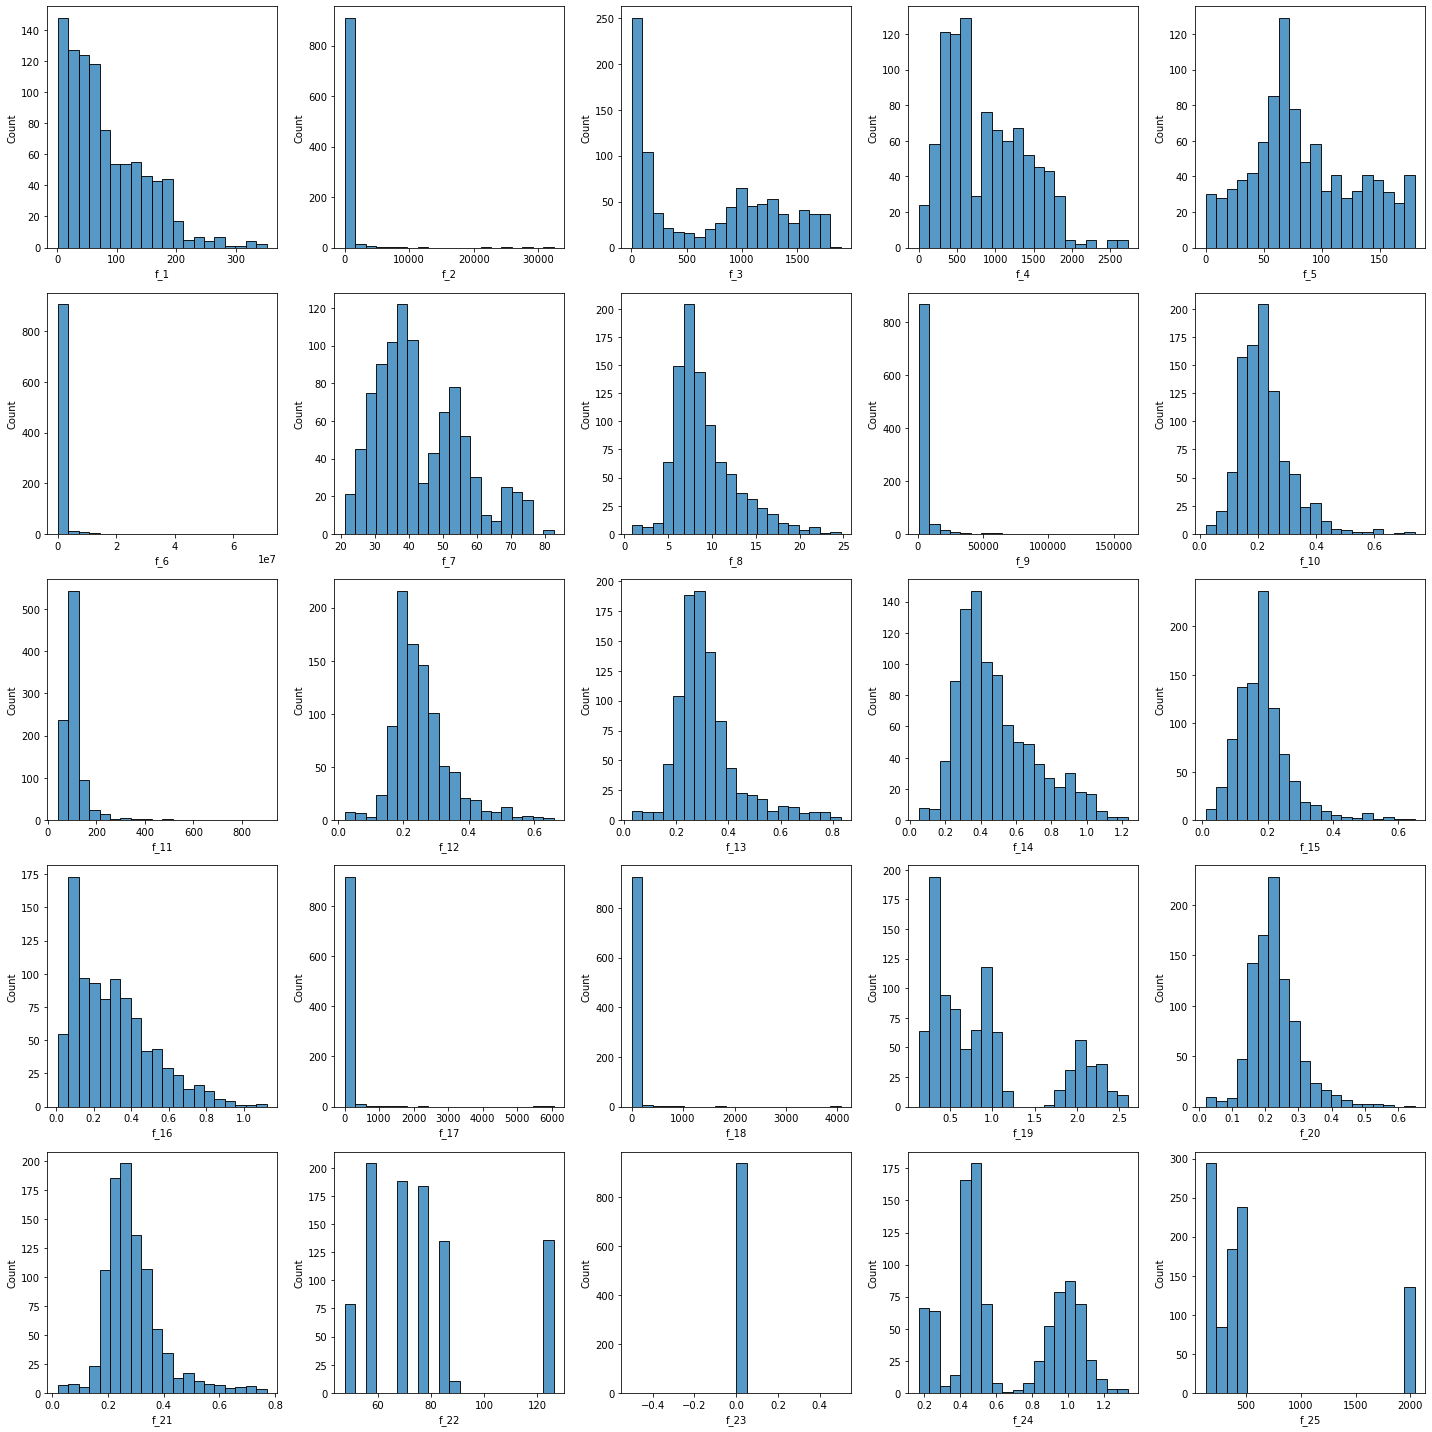

In [8]:
plt.figure(figsize=(20, 20))

for i, col in enumerate(features[0:25]):
    ax = plt.subplot(5, 5, i+1)
    sns.histplot(df[col], bins = 20, ax=ax)
plt.tight_layout()

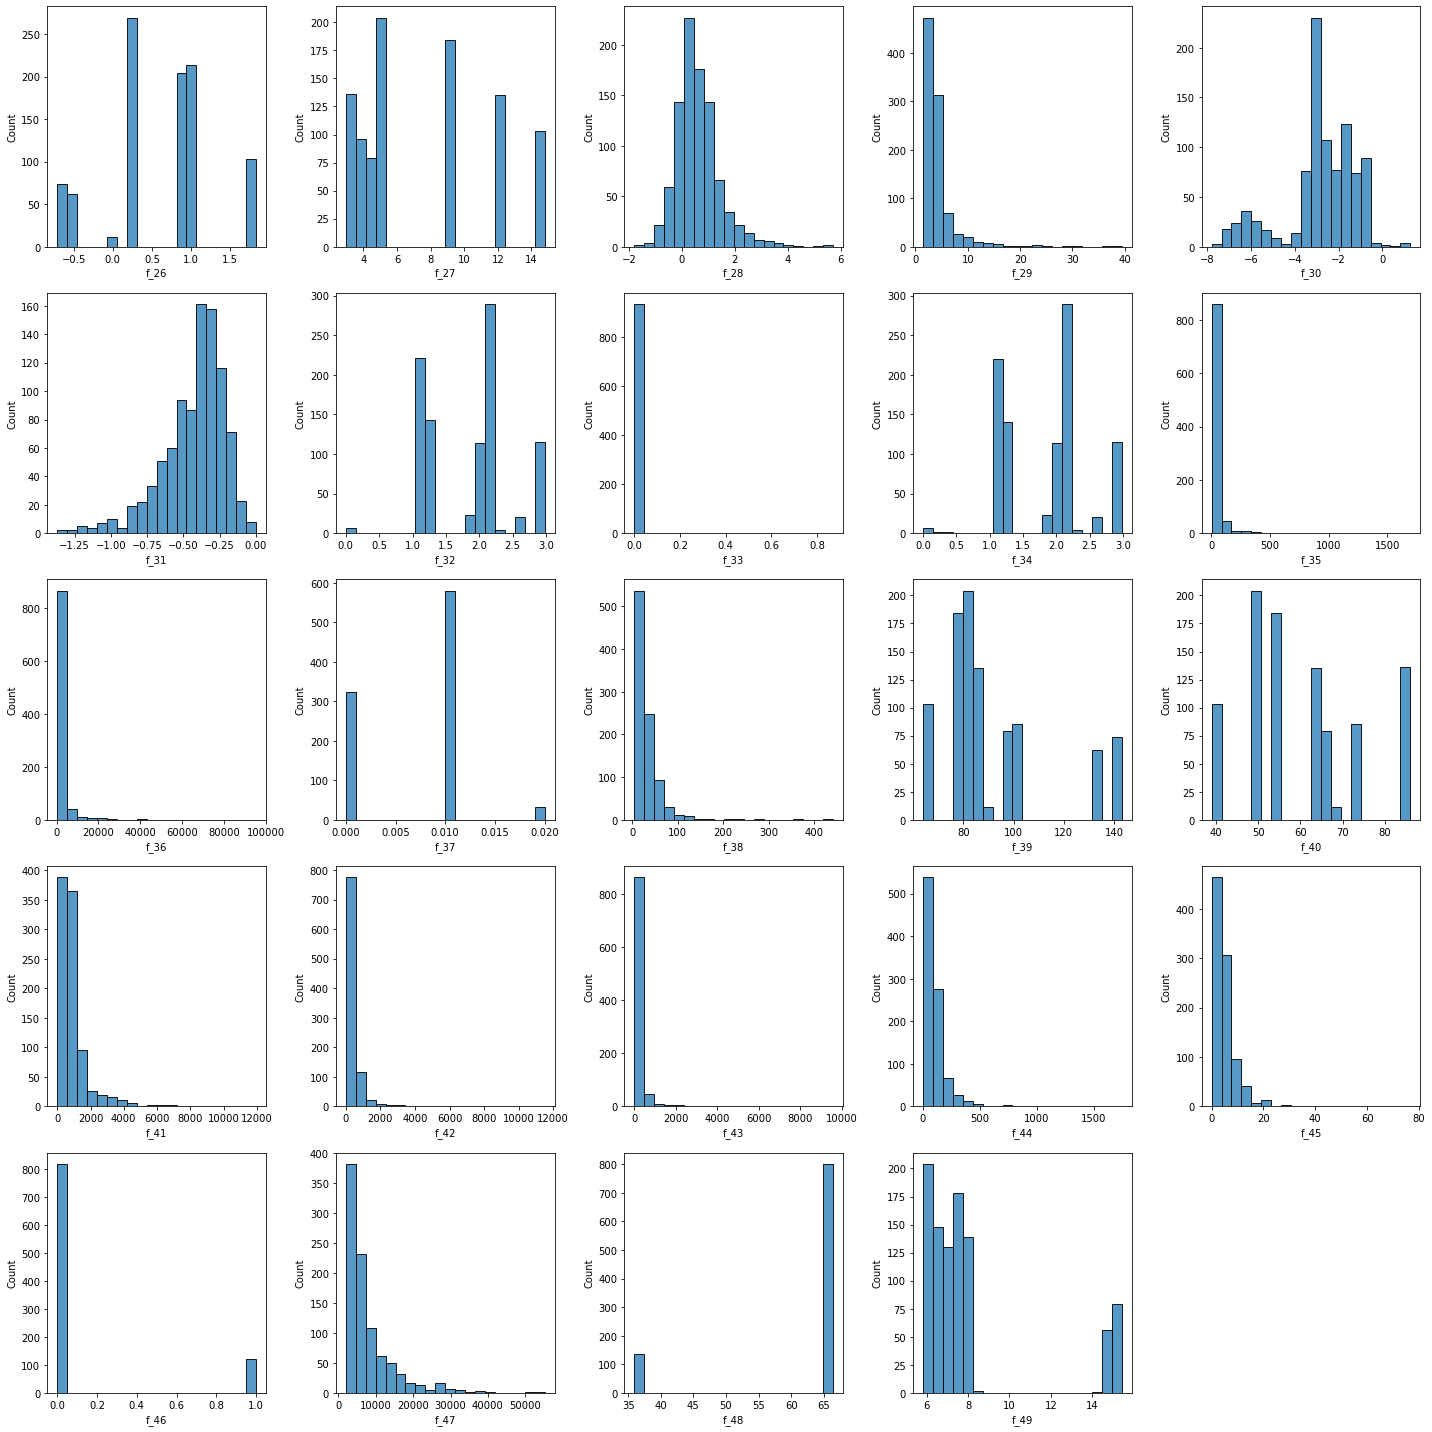

In [9]:
plt.figure(figsize=(20, 20))

for i, col in enumerate(features[25:]):
    ax = plt.subplot(5, 5, i+1)
    sns.histplot(df[col], bins = 20, ax=ax)
plt.tight_layout()

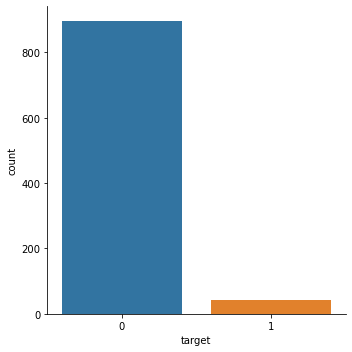

In [10]:
sns.catplot(x = 'target', kind = "count", data = df)

In [11]:
for col in features:
    if(df[col].unique().size < 10):
        print(col, ' : ', df[col].unique())

f_22  :  [ 87.65  75.26  67.87  85.22 126.08 123.47  47.66  69.09  55.85]
f_23  :  [0]
f_25  :  [ 132.78  351.67  421.21  422.12 2025.42 2036.8   204.34  239.69  221.97]
f_26  :  [-0.01  0.18  1.83  1.01 -0.53 -0.71  0.97  0.87]
f_27  :  [ 3.78  9.24 14.78 12.06  3.01  2.96  4.66  3.83  5.07]
f_33  :  [0.   0.01 0.87 0.86]
f_37  :  [0.   0.01 0.02]
f_39  :  [ 89  78  64  85 133 143  99 102  82]
f_40  :  [69 55 39 63 85 86 67 73 50]
f_46  :  [0 1]


- After the initial analysis of the dataset we can make the following conclusions:
1. There are a lot of features in the dataset in general, the scale and distribution differs from feature to feature.
2. There is no NULL values in the dataset which is good.
3. There are some features that have low number of unique values. We have taken a look at those that have less than 10 unique values (from 937 total) and might not be so useful for the modeling.
4. Target column count plot shows class imbalance which should be taken into account when evaluating models.
5. It can be challenging to draw a lot of conclusions from such data since it has already been preprocessed by a computer vision algorithm and unfortunately there is no data about this algorithm, which features represent which part of the image, etc. 


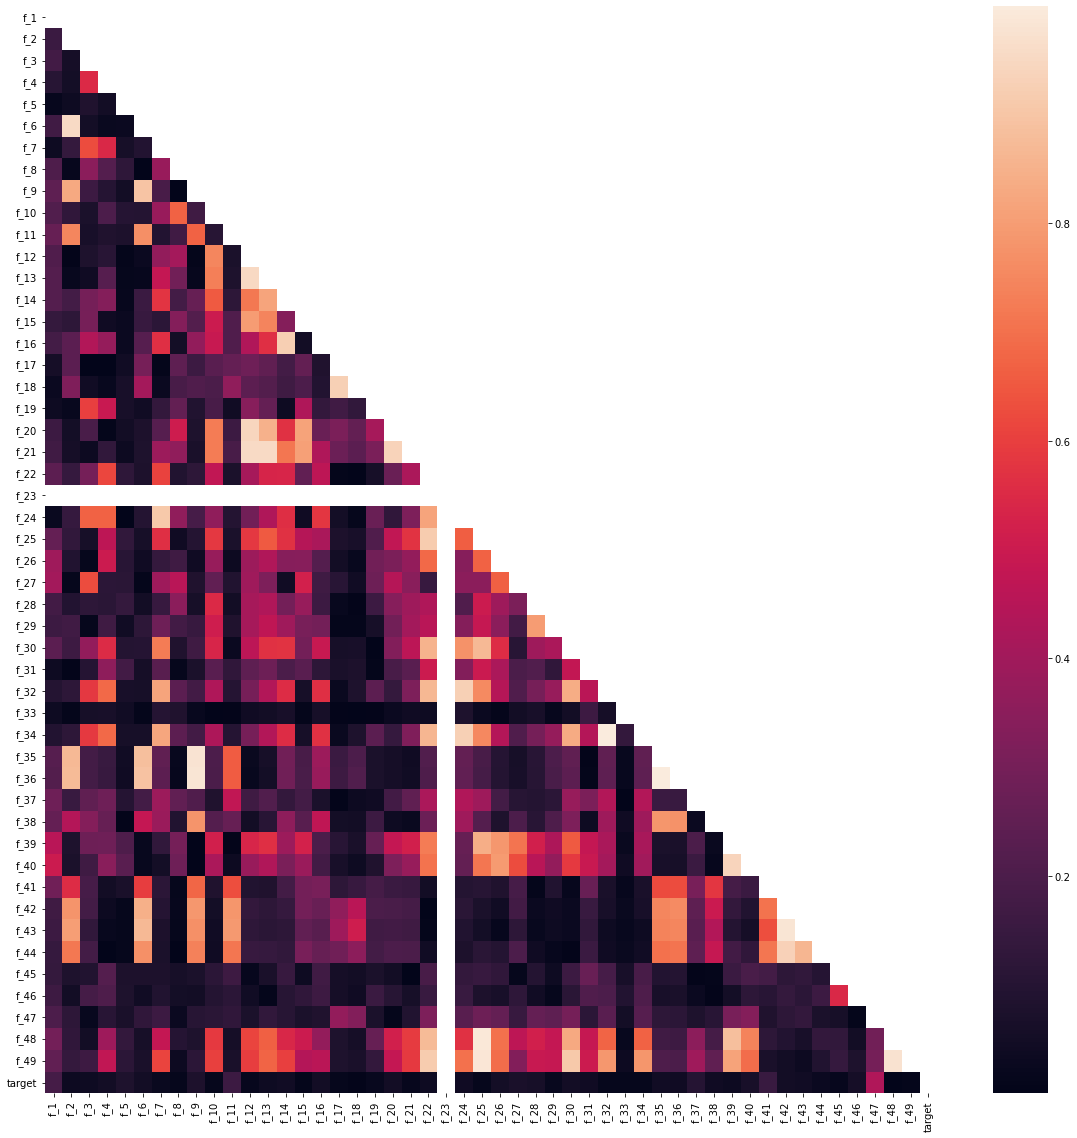

In [12]:
plt.figure(figsize=(20, 20))

corrMatrix = df.corr().abs()
mask = np.triu(np.ones_like(corrMatrix))
sns.heatmap(corrMatrix, mask=mask)

plt.show()

- Correlation matrix shows that there are cases of moderate and strong correlation between features. At the same time there is no strong linear dependency between target variable and any of the features.

# Model Training

In [13]:
def split_data(data):
    
    df = data.copy()
    
    df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
    df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

    print('Train size:', len(df_train), 
          '\nVal size:', len(df_val),
          '\nTest size:',len(df_test))
    
    df_train = df_train.reset_index(drop = True)
    df_val = df_val.reset_index(drop = True)
    df_test = df_test.reset_index(drop = True)
    
    y_train = df_train['target'].values
    y_val = df_val['target'].values
    y_test = df_test['target'].values
    
    del df_train['target']
    del df_val['target']
    del df_test['target']
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

## Basic Logistic Regression 

In [14]:
def train_log_reg(df_train, df_val, C = 1.0):
    
    train_dict = df_train.to_dict(orient = 'records')
    val_dict = df_val.to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)

    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000, random_state = 1)
    model.fit(X_train, y_train)
    
    print('Model coefficients:')
    print(model.intercept_[0].round(3))
    print(model.coef_[0].round(3))
    
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    score = round(roc_auc_score(y_val, y_pred_proba),3)
    
    print('ROC_AUC Score:', score)
    
    return score

In [15]:
data = df.copy()
data.drop(['f_1', 'f_23'], axis=1, inplace=True)

In [16]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)
features = df_full_train.iloc[:,:-1].columns

for C in tqdm([0.01, 0.1, 1, 10]):
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

    scores_cv = []
    step = 0
    
    print('C: ', C)

    for train_idx, val_idx in kfold.split(df_full_train):
    
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train['target'].values
        y_val = df_val['target'].values
        
        train_dict = df_train[features].to_dict(orient = 'records')
        val_dict = df_val[features].to_dict(orient = 'records')
        
        dv = DictVectorizer(sparse = False)
        
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
    
        model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000, random_state = 1) 
        model.fit(X_train, y_train)
    
        #predict 
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        print('AUC: ', auc_score, '\n')
        step += 1
    
        scores_cv.append(auc_score)
        
    print('mean - std : %.3f +- %.3f' % (np.mean(scores_cv), np.std(scores_cv)))
    print('\n\n')

Train size: 561 
Val size: 188 
Test size: 188


  0%|          | 0/4 [00:00<?, ?it/s]

C:  0.01
AUC:  0.8991545893719807 

AUC:  0.9571917808219178 

AUC:  0.976027397260274 

AUC:  0.9795918367346939 

AUC:  0.93006993006993 

mean - std : 0.948 +- 0.030



C:  0.1
AUC:  0.8900966183574879 

AUC:  0.9520547945205479 

AUC:  0.9674657534246576 

AUC:  0.9795918367346939 

AUC:  0.9300699300699301 

mean - std : 0.944 +- 0.032



C:  1
AUC:  0.9027777777777777 

AUC:  0.9571917808219178 

AUC:  0.9674657534246576 

AUC:  0.9841269841269841 

AUC:  0.9184149184149184 

mean - std : 0.946 +- 0.031



C:  10
AUC:  0.8907004830917874 

AUC:  0.9571917808219178 

AUC:  0.976027397260274 

AUC:  0.9795918367346939 

AUC:  0.9300699300699301 

mean - std : 0.947 +- 0.033





In [17]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)
train_log_reg(df_train, df_val, 1.0)

Train size: 561 
Val size: 188 
Test size: 188
Model coefficients:
-0.0
[-0.     0.001 -0.    -0.    -0.    -0.     0.     0.002 -0.014  0.
  0.002 -0.    -0.    -0.007 -0.     0.    -0.001 -0.002  0.     0.
 -0.001 -0.     0.    -0.    -0.    -0.    -0.    -0.002 -0.    -0.006
 -0.023  0.    -0.017  0.     0.002 -0.001 -0.011 -0.005 -0.     0.
 -0.016 -0.001 -0.005 -0.    -0.019 -0.003  0.001]
ROC_AUC Score: 0.897


0.897

In [18]:
#Scaled dataframe creation
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data.iloc[:,:-1])

df_scaled = pd.DataFrame(df_scaled, columns = data.iloc[:,:-1].columns)
df_scaled['target'] = data.iloc[:,-1:]

In [19]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df_scaled)

train_log_reg(df_train, df_val)

Train size: 561 
Val size: 188 
Test size: 188
Model coefficients:
-4.225
[-0.333 -0.291  0.142  0.564  0.01  -0.285  0.094 -0.152 -0.761 -0.278
  0.006 -0.454 -0.167  0.194 -0.505 -0.354 -0.516 -0.417  0.376 -0.263
 -0.551 -0.173  0.099 -0.305 -0.014 -0.301 -0.396 -0.407 -0.116 -0.102
 -0.113  0.012 -0.546  0.653  0.056  0.003 -0.324 -0.222  0.076  1.28
  0.286 -0.299 -0.061  0.092 -0.717  0.289  0.237]
ROC_AUC Score: 0.875


0.875

- Two Logistic Regression models were trained and estimated. Different regularization parameters C were tested. Basic Logistic Regression on unscaled data performed slightly better than the model trained on scaled data. Now let's try some other models.

## Random Forest

In [20]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)

Train size: 561 
Val size: 188 
Test size: 188


In [21]:
train_dict = df_train.to_dict(orient = 'records')
val_dict = df_val.to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [22]:
rf = RandomForestClassifier(n_estimators = 10, 
                           random_state = 1, 
                           n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [23]:
y_pred = rf.predict(X_val)
y_pred_proba = rf.predict_proba(X_val)[:, 1]

print(roc_auc_score(y_val, y_pred))

0.5416666666666666


- Basic RF Model resulted in poor ROC_AUC score. Now let's try to take a look at other metrics and tune some parameters.

In [24]:
thresholds = np.linspace(0.0, 1.0, 101)

scores_thr = []

actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

for t in thresholds:
    
    predicted_pos = (y_pred_proba >= t)
    predicted_neg = (y_pred_proba < t)
    
    tp = (predicted_pos & actual_pos).sum()
    tn = (predicted_neg & actual_neg).sum()
    fp = (predicted_pos & actual_neg).sum()
    fn = (predicted_neg & actual_pos).sum()
    
    scores_thr.append((t, tp, tn, fp, fn))
    
cols = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores_thr = pd.DataFrame(scores_thr, columns = cols)

In [25]:
df_scores_thr['precision'] = (df_scores_thr['tp'])/(df_scores_thr['tp'] + df_scores_thr['fp'])
df_scores_thr['recall'] = (df_scores_thr['tp'])/(df_scores_thr['tp'] + df_scores_thr['fn'])

df_scores_thr['tpr'] = (df_scores_thr['tp'])/(df_scores_thr['tp'] + df_scores_thr['fn'])
df_scores_thr['fpr'] = df_scores_thr['fp'] / (df_scores_thr['fp'] + df_scores_thr['tn'])

df_scores_thr['f1'] = (2 * df_scores_thr['precision'] * df_scores_thr['recall']) \
                        / (df_scores_thr['precision'] + df_scores_thr['recall'])

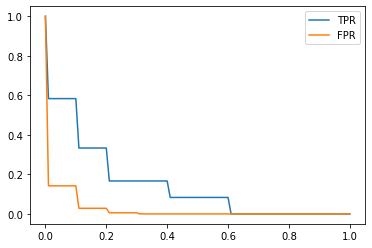

In [26]:
plt.plot(df_scores_thr.threshold, df_scores_thr['tpr'], label='TPR')
plt.plot(df_scores_thr.threshold, df_scores_thr['fpr'], label='FPR')
plt.legend()

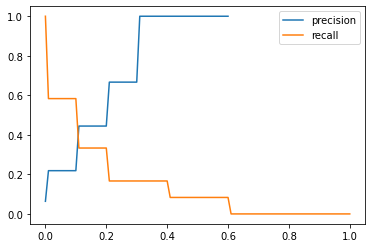

In [27]:
plt.plot(df_scores_thr['threshold'], df_scores_thr['precision'], label = 'precision')
plt.plot(df_scores_thr['threshold'], df_scores_thr['recall'], label = 'recall')

plt.legend()

In [28]:
df_scores_thr.sort_values(by = ['f1'], ascending = False).head()

,threshold,tp,tn,fp,fn,precision,recall,tpr,fpr,f1
15,0.15,4,171,5,8,0.444444,0.333333,0.333333,0.028409,0.380952
11,0.11,4,171,5,8,0.444444,0.333333,0.333333,0.028409,0.380952
20,0.20,4,171,5,8,0.444444,0.333333,0.333333,0.028409,0.380952
19,0.19,4,171,5,8,0.444444,0.333333,0.333333,0.028409,0.380952
18,0.18,4,171,5,8,0.444444,0.333333,0.333333,0.028409,0.380952


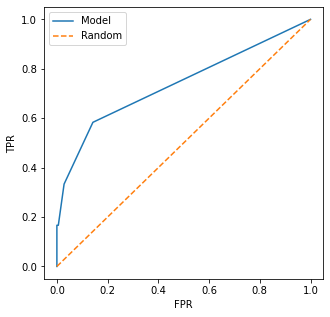

In [29]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores_thr.fpr, df_scores_thr.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [30]:
scores = []
n_estimators = np.linspace(10, 100, 10, dtype = int)

for n in n_estimators:
    
    rf_test = RandomForestClassifier(n_estimators = n, random_state = 1)
    rf_test.fit(X_train, y_train)
    
    y_pred = rf_test.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    print('n: ', n, ', ROC_AUC: ', score)
    
    scores.append(score)

n:  10 , ROC_AUC:  0.5416666666666666
n:  20 , ROC_AUC:  0.5
n:  30 , ROC_AUC:  0.5
n:  40 , ROC_AUC:  0.5
n:  50 , ROC_AUC:  0.5
n:  60 , ROC_AUC:  0.5
n:  70 , ROC_AUC:  0.5
n:  80 , ROC_AUC:  0.5416666666666666
n:  90 , ROC_AUC:  0.5416666666666666
n:  100 , ROC_AUC:  0.5


In [31]:
scores_depth_n = []

max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]

for d in max_depth:
    for n in n_estimators:
        
        rf_test = RandomForestClassifier(n_estimators = n, max_depth = d, random_state = 1)
        rf_test.fit(X_train, y_train)
        
        y_pred = rf_test.predict(X_val)
        
        score = roc_auc_score(y_val, y_pred)
        scores_depth_n.append((d, n, score))
        
cols = ['depth', 'n_est', 'roc_auc']
df_scores_depth_n = pd.DataFrame(scores_depth_n, columns = cols)

In [32]:
df_scores_depth_n.sort_values(by = ['roc_auc']).head()

,depth,n_est,roc_auc
0,1,10,0.5
74,8,50,0.5
73,8,40,0.5
72,8,30,0.5
71,8,20,0.5


- Random Forest models show general poor performance. Tuning the parameters did not improve the results.

## XGBoost

In [45]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)

Train size: 561 
Val size: 188 
Test size: 188


In [46]:
train_dict = df_train.to_dict(orient = 'records')
val_dict = df_val.to_dict(orient = 'records')
dv = DictVectorizer(sparse = False)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [47]:
feature_names_out = dv.get_feature_names_out()

dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feature_names_out)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = feature_names_out)

In [48]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 3,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'auc'}

In [49]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round = 20, evals = watchlist)

[0]	train-auc:0.78309	val-auc:0.61932
[1]	train-auc:0.78309	val-auc:0.61932
[2]	train-auc:0.94496	val-auc:0.70028
[3]	train-auc:0.97735	val-auc:0.78954
[4]	train-auc:0.97799	val-auc:0.78527
[5]	train-auc:0.98221	val-auc:0.81510
[6]	train-auc:0.98346	val-auc:0.80848
[7]	train-auc:0.98589	val-auc:0.79617
[8]	train-auc:0.98789	val-auc:0.80776
[9]	train-auc:0.99048	val-auc:0.80137
[10]	train-auc:0.99308	val-auc:0.79853
[11]	train-auc:0.99416	val-auc:0.79380
[12]	train-auc:0.99557	val-auc:0.80871
[13]	train-auc:0.99643	val-auc:0.81321
[14]	train-auc:0.99686	val-auc:0.83901
[15]	train-auc:0.99708	val-auc:0.83807
[16]	train-auc:0.99730	val-auc:0.84943
[17]	train-auc:0.99762	val-auc:0.85085
[18]	train-auc:0.99838	val-auc:0.86222
[19]	train-auc:0.99838	val-auc:0.86269


In [50]:
y_pred = xgb_model.predict(dval)

print(roc_auc_score(y_val, y_pred))

0.8626893939393939


- When training XGBoost model various parameters combinations were tried as well: different learning rate values, different numbers of round, tree depth. As a result, the optimal combination was found. Model scores are close to the values obtained from Logistic Regression.

## Evaluation on test data

In [39]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)

df_full_train = df_full_train.reset_index(drop = True)

Train size: 561 
Val size: 188 
Test size: 188


In [40]:
y_full_train = df_full_train['target'].values

del df_full_train['target']

In [41]:
dv = DictVectorizer(sparse=False)

dicts_full_train = df_full_train.to_dict(orient = 'records')
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient = 'records')
X_test = dv.transform(dicts_test)

feature_names_out = dv.get_feature_names_out()

In [42]:
#Best XGB
dfulltrain = xgb.DMatrix(X_full_train, label = y_full_train, feature_names = feature_names_out)
dtest = xgb.DMatrix(X_test, feature_names = feature_names_out)
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round = 20)

y_pred_xgb = xgb_model.predict(dtest)

print("ROC_AUC: %.4f" % roc_auc_score(y_test, y_pred_xgb))

ROC_AUC: 0.9342


In [43]:
#Best Logistic Regression
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 1)
model.fit(X_full_train, y_full_train)
    
y_pred_lr = model.predict(X_test)

print("ROC_AUC: %.4f" % roc_auc_score(y_test, y_pred_lr))

ROC_AUC: 0.7415


- Compared on test data, XGBoost showed surprisingly good results on the test data.